## Antithetic Variates

Let's write an option on asset $S_1$ and another option on asset $S_2$ that is perfectly negatively correlated with $S_1$ and which currently has the same price. $S_1$ and $S_2$ satisfy the following Stochastic Differential Equations:

$\large dS_{1,t} = rdS_{1,t}dt+\sigma dS_{1,t}dz_t$

$\large dS_{2,t} = rdS_{2,t}dt-\sigma dS_{2,t}dz_t$

Since the price and volatility of the two assets are identical, so is the value of these two options. However, the variance of a portfolio pay-off containing both of these contracts is much less than the variance of the pay-off of each individual contract. In essence we are removing the large spike in probability distribution of a single contract pay-off. i.e. Basic Intuition: when one option pays out, the other does not.

### Benefits of Antithetic Variance Reduction

1. By using pairs $(\epsilon_i, -\epsilon_i)$ in the simulation we can now achieve a more accurate estimate from M pairs of $(C_{T,i}, \bar{C}_{T,i})$ than from 2M of ${C}_{T,i}$.

2. It is also computationally cheaper to generate the pair $(C_{T,i}, \bar{C}_{T,i})$ than two instances of $C_{T,i}$

3. Method also ensures that mean of the normally distributed samples $\epsilon$ is exactly zero with helps improve the simulation

In [1]:
#Import dependencies
import math
import numpy as np
import pandas as pd
import datetime
import scipy.stats as stats
import matplotlib.pyplot as plt

#Implementation of Antithetic Variate

To implement an antithetic variate we create a hypothetical asset which is perfectly negatively correlated with the original asset.

In [17]:
# Inital derivative parameters
S = 101.15 #Stock Price
K = 98.01 #Strike Price
vol = 0.0991 #Volatility (%)
r = 0.015 #Risk-free rate (%)
N = 10 #Number of time steps
M = 1000 #Number of simulations

market_value = 3.86 #market value of option
T = ((datetime.date(2022,3,17)-datetime.date(2022,1,17)).days+1)/365 #time in years
print(T)

0.1643835616438356


##Slow Solution - Steps

We break it down into slow discretised steps, although for the purposes of a European Call Option we do not have to take steps as the discretisation perfectly represents the SDE.

In [18]:
# Precompute constants
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
lnS = np.log(S)

# Standard Error Placeholders
sum_CT = 0
sum_CT2 = 0

# Monte Carlo Method
for i in range(M):
    lnSt1 = lnS
    lnSt2 = lnS
    for j in range(N):
        # Perfectly Negatively Correlated Assets
        epsilon = np.random.normal()
        lnSt1 = lnSt1 + nudt + volsdt*epsilon
        lnSt2 = lnSt2 + nudt - volsdt*epsilon

    ST1 = np.exp(lnSt1)
    ST2 = np.exp(lnSt2)
    CT = 0.5 * ( max(0, ST1 - K) + max(0, ST2 - K) )
    sum_CT = sum_CT + CT
    sum_CT2 = sum_CT2 + CT*CT

# Compute Expectation and SE
C0 = np.exp(-r*T)*sum_CT/M
sigma = np.sqrt( (sum_CT2 - sum_CT*sum_CT/M)*np.exp(-2*r*T) / (M-1) )
SE = sigma/np.sqrt(M)

print("Call value is ${0} with SE +/- {1}".format(np.round(C0,2),np.round(SE,2)))

Call value is $3.85 with SE +/- 0.03


##Fast Solution - Vectorised

For simple processes where the SDE does not need to be approximated like in the case of Brownian Motion used for calculating a European Option price, we can just simulate the variables at the final Time Step as Brownian Motion scales with time and independent increments.

In [21]:
#precompute constants
N = 1
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
lnS = np.log(S)

#Monte Carlo Method
Z = np.random.normal(size=(N, M))
delta_lnSt1 = nudt + volsdt*Z
delta_lnSt2 = nudt - volsdt*Z
lnSt1 = lnS + np.cumsum(delta_lnSt1, axis=0)
lnSt2 = lnS + np.cumsum(delta_lnSt2, axis=0)

#Compute Expectation and SE
ST1 = np.exp(lnSt1)
ST2 = np.exp(lnSt2)
CT = 0.5 * ( np.maximum(0, ST1[-1] - K) + np.maximum(0, ST2[-1] - K))
C0 = np.exp(-r*T)*np.sum(CT)/M

sigma = np.sqrt( np.sum( (CT - C0)**2) / (M-1) )
SE = sigma/np.sqrt(M)

print("Call value is ${0} with SE +/- {1}".format(np.round(C0,2),np.round(SE,2)))

Call value is $3.86 with SE +/- 0.03


##Compare without Anithetic Variate

In [28]:
#precompute constants
N = 1
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
lnS = np.log(S)

# Monte Carlo Method
Z = np.random.normal(size=(N, M))
delta_lnSt = nudt + volsdt*Z
lnSt = lnS + np.cumsum(delta_lnSt, axis=0)
lnSt = np.concatenate( (np.full(shape=(1, M), fill_value=lnS), lnSt ) )

# Compute Expectation and SE
ST = np.exp(lnSt)
CT = np.maximum(0, ST - K)
C0w = np.exp(-r*T)*np.sum(CT[-1])/M

sigma = np.sqrt( np.sum( (CT[-1] - C0)**2) / (M-1) )
SEw = sigma/np.sqrt(M)

print("Call value is ${0} with SE +/- {1}".format(np.round(C0,2),np.round(SE,2)))

Call value is $3.86 with SE +/- 0.03


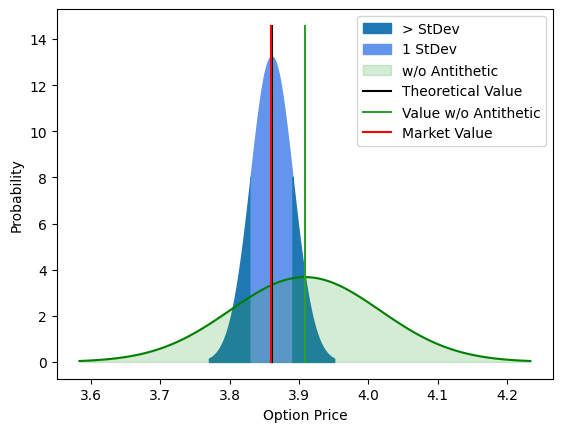

In [25]:
x1 = np.linspace(C0-3*SE, C0-1*SE, 100)
x2 = np.linspace(C0-1*SE, C0+1*SE, 100)
x3 = np.linspace(C0+1*SE, C0+3*SE, 100)
xw = np.linspace(C0w-3*SEw, C0w+3*SEw, 100)

s1 = stats.norm.pdf(x1, C0, SE)
s2 = stats.norm.pdf(x2, C0, SE)
s3 = stats.norm.pdf(x3, C0, SE)
sw = stats.norm.pdf(xw, C0w, SEw)

plt.fill_between(x1, s1, color='tab:blue',label='> StDev')
plt.fill_between(x2, s2, color='cornflowerblue',label='1 StDev')
plt.fill_between(x3, s3, color='tab:blue')
plt.plot(xw, sw, 'g-')
plt.fill_between(xw, sw, alpha=0.2, color='tab:green', label='w/o Antithetic')

plt.plot([C0,C0],[0, max(s2)*1.1], 'k',
        label='Theoretical Value')
plt.plot([C0w,C0w],[0, max(s2)*1.1], color='tab:green',
        label='Value w/o Antithetic')
plt.plot([market_value,market_value],[0, max(s2)*1.1], 'r',
        label='Market Value')

plt.ylabel("Probability")
plt.xlabel("Option Price")
plt.legend()
plt.show()